### import

In [3]:
import torch
from torch import nn
from torch.functional import F
from torch.distributions import Multinomial, Categorical
from torch import optim
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import numpy as np
import importlib as imp
import actor
import envs
import utils
imp.reload(actor)
imp.reload(envs)
imp.reload(utils)
from actor import Actor, Actor_GRU, Critic, MLPCritic
from envs import HospitalEnv
from utils import mlp_sample, ppo_update, overflow_sample, compute_gae_adv
from env_config import ENV_CONFIG as config
from tqdm import tqdm

In [3]:
x = [torch.tensor(1), torch.tensor(2)]

In [6]:
x = [
        303.4542541503906,
        303.6099853515625,
        282.95526123046875,
        288.9100036621094,
        292.83026123046875,
        278.3194885253906,
        302.75225830078125,
        293.02374267578125,
        291.7130126953125,
        301.3945007324219,
        270.86224365234375,
        293.04974365234375,
        302.7449951171875,
        282.8392639160156,
        289.3507385253906,
        294.728759765625,
        281.40673828125,
        287.9010009765625,
        268.8290100097656,
        295.69073486328125,
        276.0744934082031,
        279.5459899902344,
        290.00250244140625,
        294.69573974609375,
        289.0469970703125
    ]

In [7]:
torch.tensor(x).mean()

tensor(289.4293)

tensor(0.3548)

In [1]:
import torch

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
epochs = 10
costs_mean = []
act_loss_mean = []
crtc_loss_mean = []
env = HospitalEnv(config)
act = Actor_GRU(config)
crtc = LinearCritic(config)
optimizer_actor = Adam(act.parameters(), lr=5e-4)
optimizer_critic = Adam(crtc.parameters(), lr=1e-3)
scheduler_actor = CosineAnnealingLR(optimizer_actor, T_max=epochs, eta_min=1e-4)
# scheduler_critic = CosineAnnealingLR(optimizer_actor, T_max=5, eta_min=1e-4)
iters = 0

In [4]:
config["Simulation_days"] = 10000

In [153]:
config["Clipping_parameter"] = 0.5
config["max_norm"] = 1
config["lam"] = 0.95
config["gamma"] = 0.99

In [5]:
for i in range(5):
    crtc.loss = []
    act.loss = []
    iters += 1
    trajectory = mlp_sample(env, act, config, is_random=False)
    states = torch.stack([t['state'] for t in trajectory]).float()
    actions = torch.stack([t['action'] for t in trajectory]).float()
    costs = torch.tensor([t['cost'] / 100 for t in trajectory], dtype=torch.float32)
    next_states = torch.stack([t['next_state'] for t in trajectory]).float()

    # Recompute log_probs using current logits for compatibility with PPO update
    logits = torch.stack([t['logits'] for t in trajectory]).float()
    old_probs = F.log_softmax(logits, dim=-1)

    memory = (states, actions, old_probs, costs, next_states)
    ppo_update(act, crtc, memory, optimizer_actor, optimizer_critic, config)
    # scheduler_actor.step()

    costs_mean.append(costs.mean() * 8)
    act_loss_mean.append(sum(act.loss) / len(act.loss))
    crtc_loss_mean.append(sum(crtc.loss) / len(crtc.loss))
    print(f"Daily Average Cost: {costs_mean[-1]:.2f}")
    print(f"Average Critic Loss: {crtc_loss_mean[-1]:0f}")
    print(f"Average Actor Loss: {act_loss_mean[-1]:.3f}")

Sample:  55%|█████▌    | 44043/80000 [03:41<03:15, 183.98it/s]

tensor([0.9833, 0.9531, 0.8358, 0.9677, 1.0323, 0.2333, 0.1406, 0.1343, 0.1774,
        0.2581, 4.0000])

In [21]:
CHECKPOINT_PATH = 'checkpoint'

torch.save({
    'update_steps': len(act.loss),
    'act_state_dict': act.state_dict(),
    'crtc_state_dict': crtc.state_dict(),
    'optimizer_actor_state_dict': optimizer_actor.state_dict(),
    'optimizer_critic_state_dict': optimizer_actor.state_dict(),
}, CHECKPOINT_PATH)

print(f"Checkpoint saved to {CHECKPOINT_PATH}")

Checkpoint saved to checkpoint


In [28]:
# advantage 计算
from utils import compute_gae_adv
rewards = torch.tensor([-c for c in costs])
with torch.no_grad():
    advantages = compute_gae_adv(crtc, next_states, states, rewards)
    v_s = crtc(states)
    print(advantages)
v_s.mean(), advantages.mean()

tensor([13.1403, 12.4788, 12.6737,  ..., -0.8509,  0.7561,  1.2805])


(tensor(-31.8163), tensor(-1.6550))

In [30]:
with torch.no_grad():
    batch_slice = slice(200, 264)
    s = states[batch_slice]
    logp_old = old_probs[batch_slice]
    l, _ = act(s)
    logp_new = F.log_softmax(l, dim=-1)
    f = actions[batch_slice]
    log_ratio = ((logp_new - logp_old) * f).sum(dim=(1, 2))
    ratio = torch.exp(log_ratio)
ratio, log_ratio

(tensor([0.1685, 0.9146, 0.2540, 1.3304, 1.1812, 1.0000, 1.0000, 1.0000, 0.9992,
         1.0284, 0.8279, 0.9055, 0.9294, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 0.9173, 0.9294, 1.0006, 1.0000, 1.0023, 1.1123, 1.4092, 1.4758,
         0.7974, 0.7843, 0.9801, 0.9801, 1.0000, 1.0000, 1.0732, 1.1052, 0.4354,
         0.7219, 1.1011, 0.9816, 1.0000, 0.9601, 2.3714, 1.7528, 2.0612, 1.4014,
         1.0744, 1.1051, 1.0000, 0.9484, 0.7143, 1.3653, 1.1394, 0.3206, 0.9105,
         1.7243, 0.9927, 0.9769, 0.4861, 1.2586, 1.6503, 1.0497, 2.0501, 0.9729,
         1.0005]),
 tensor([-1.7806e+00, -8.9316e-02, -1.3704e+00,  2.8550e-01,  1.6655e-01,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -8.1436e-04,  2.7998e-02,
         -1.8888e-01, -9.9262e-02, -7.3184e-02,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -8.6290e-02,
         -7.3217e-02,  6.0412e-04,  0.0000e+00,  2.3092e-03,  1.0646e-01,
          3.4305e-01,  3.8918e-01, -2.2634e-

In [31]:
crtc_loss_mean = [l.detach().item() for l in crtc.loss]
act_loss = [l.detach().item() for l in act.loss]


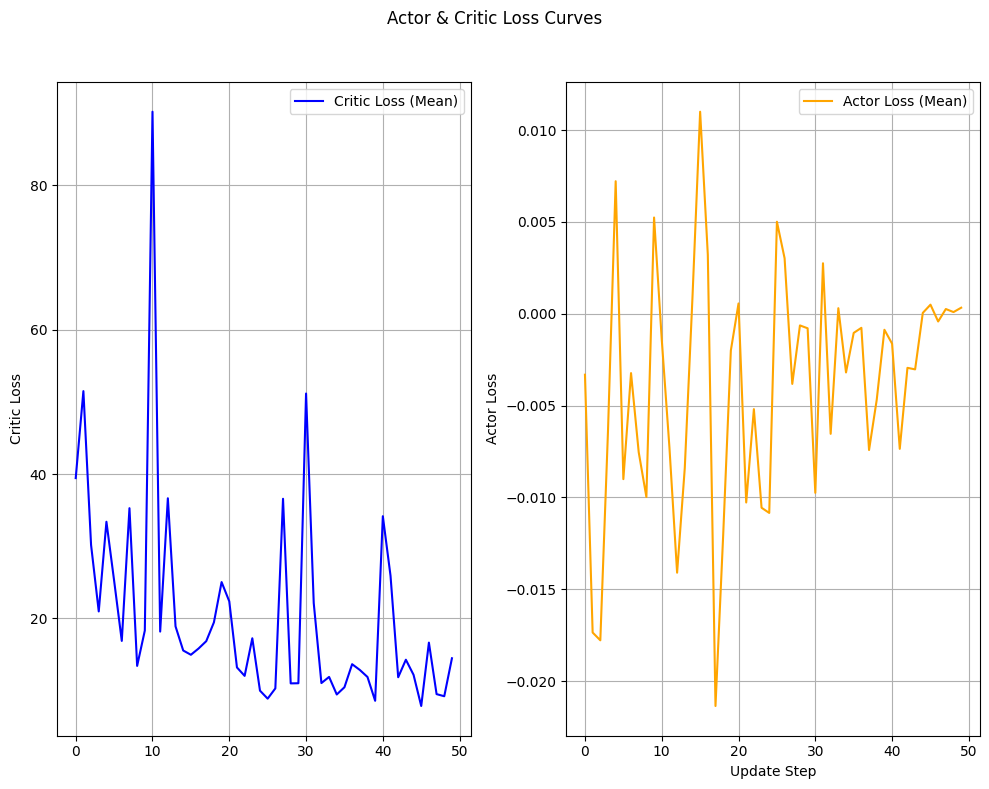

In [44]:
import matplotlib.pyplot as plt
import numpy as np
# plt.plot(crtc.loss, label="Critic Loss")
fig, axs = plt.subplots(1, 2, figsize=(10, 8), sharex=True)

axs[0].plot(torch.tensor(crtc_loss_mean).detach(), label="Critic Loss (Mean)", color='blue')
axs[0].set_ylabel("Critic Loss")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(torch.tensor(act_loss_mean).detach(), label="Actor Loss (Mean)", color='orange')
axs[1].set_xlabel("Update Step")
axs[1].set_ylabel("Actor Loss")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Actor & Critic Loss Curves")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

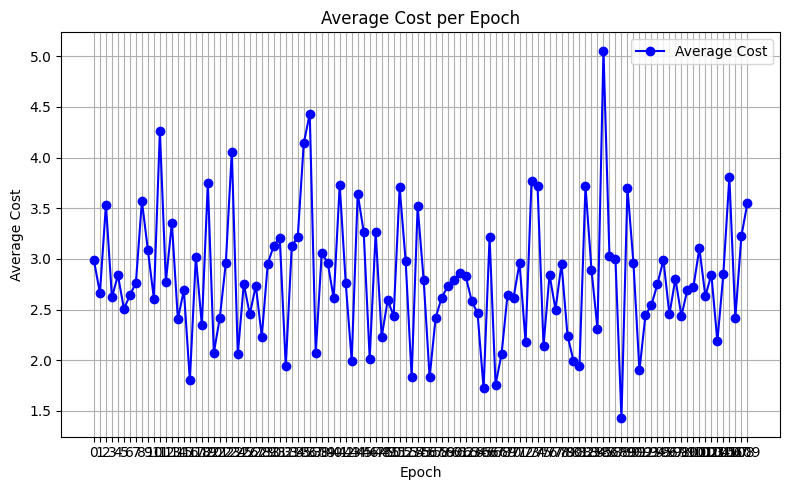

In [ ]:
epochs = list(range(len(costs_mean)))
plt.figure(figsize=(8, 5))
plt.plot(epochs, costs_mean, marker='o', linestyle='-', color='b', label='Average Cost')
plt.title('Average Cost per Epoch')
plt.xlabel('Epoch')
plt.xticks(epochs)  # 设置横轴为整数刻度
plt.ylabel('Average Cost')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()